<a href="https://colab.research.google.com/github/jamespan1118/Xenopus_signal_processing/blob/main/Viterbi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Objective: Create segments that contains bouts of calling

####Preparation work

Input: original recording

Output: segments of recordings containing bouts of calling

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import librosa
import os
from librosa import display
import scipy
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from scipy.io import wavfile

In [3]:
from scipy import fftpack, signal
from scipy.io.wavfile import write
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft

High-pass and Low-pass filter to remove noise

In [4]:
def load_wav(file_path, sampling_rate = 44100):
  file_name = os.path.basename(file_path)
  samples, sampling_rate = librosa.load(file_path,sr=sampling_rate)
  duration = len(samples)/sampling_rate
  return(samples, sampling_rate, duration)

def filt(samples, sampling_rate=44100, low_thresh=400, upp_thresh=5000): 
  yf = rfft(samples)
  xf = rfftfreq(len(samples), 1 / sampling_rate)
  points_per_freq = len(xf) / (sampling_rate / 2)

  target_idx_noise_lower = int(points_per_freq * low_thresh)
  target_idx_noise_upper = int(points_per_freq * upp_thresh)
  yf[: target_idx_noise_lower] = 0
  yf[target_idx_noise_upper:] = 0
  filt_signal = irfft(yf)
  return filt_signal

Rough filter for feature extraction

In [5]:
def norm_envelope(samples, sampling_rate=44100, win_length=2048, win_step=1024):
  y = np.pad(samples, win_length, mode="constant") #add 0 to front and back of the sample
    # Pads (window length) to the sequence: -->windows around sample of length 1024*5 (samples)
  x = librosa.util.frame(y, win_length, win_step) # step-size 512
  sm_env = np.sqrt(np.mean(np.abs(x)**2, axis=-2, keepdims=True)) # Question: why axis=-2? How did the dimension reduction happen?
  z_env = z_score(sm_env)
  
  frames = np.arange(z_env.shape[1])
  frames_dist=(np.array(frames) * win_step).astype(int)
  times=np.array(frames_dist) / float(sampling_rate)
  return sm_env, z_env, times

def z_score(data):
  error = math.exp(-100)
  if(np.std(data)<0.005):
    error=0.005
  z = (data)/(np.std(data)+error) # The filter's pretty strong so let's just normalize by standard deviation. But error should = threshold?
  return z

Generate the likelihood of calling at each point

In [6]:
def logistic_function(x,threshold,std):
  probability = 1/(1+math.exp(-(x-threshold)/std))
  return probability

def state_probability(z_env):
  vectorized_logistics = np.vectorize(logistic_function)
  std_normalized = np.std(z_env)
  #data points with z_score>3 categorized into yes call state
  probability_each_point = vectorized_logistics(z_env, 0.05, std_normalized)
  return probability_each_point

Generate input parameters for the viterbi algorithm

In [7]:
def prob_generate(probability_each_point):
  yes_call_prob = probability_each_point
  no_call_prob = [1-i for i in yes_call_prob]
  prob = np.row_stack((yes_call_prob,no_call_prob))
  return prob

In [8]:
#assumption that the transition between states is less likely compared to within states
yes_to_no = 0.4
no_to_yes = yes_to_no
transition_matrix = np.row_stack(([1-yes_to_no,yes_to_no],[no_to_yes,1-no_to_yes]))

In [9]:
p_init = np.array([0.5,0.5])

In [10]:
def recursive_processing(df):
  processed_start_time=[]
  processed_end_time=[]
  df_len = len(df)
  i=0
  while(i<len(df)-1):
    if(abs(df.iloc[i,1]-df.iloc[i+1,0])<5):
      #print(df.iloc[i,0],df.iloc[i+1,1])
      processed_start_time.append(df.iloc[i,0])
      processed_end_time.append(df.iloc[i+1,1])
      i=i+2
    else:
      #print(df.iloc[i,1],df.iloc[i,1])
      processed_start_time.append(df.iloc[i,0])
      processed_end_time.append(df.iloc[i,1])
      i=i+1
  
  processed_start_time.append(df.iloc[len(df)-1,0])
  processed_end_time.append(df.iloc[len(df)-1,1])

  df_processed = pd.DataFrame({'start': processed_start_time, 'end': processed_end_time})
  
  if(abs(len(df_processed)-len(df))>1):
    df_new_processed = recursive_processing(df_processed)
    #print("another round")
  else:
    return df_processed
  return df_new_processed

####testing to ensure the function works

In [10]:
file_path = '/content/drive/MyDrive/Xenopus_male_female_data/overall_copy/laevis/F832F-F837D/duets/chunks/rapping/02-F832F-F837D-220615_1835_1'

In [11]:
samples, sampling_rate, duration = load_wav(file_path)
x_time = np.arange(0,duration,1/sampling_rate)

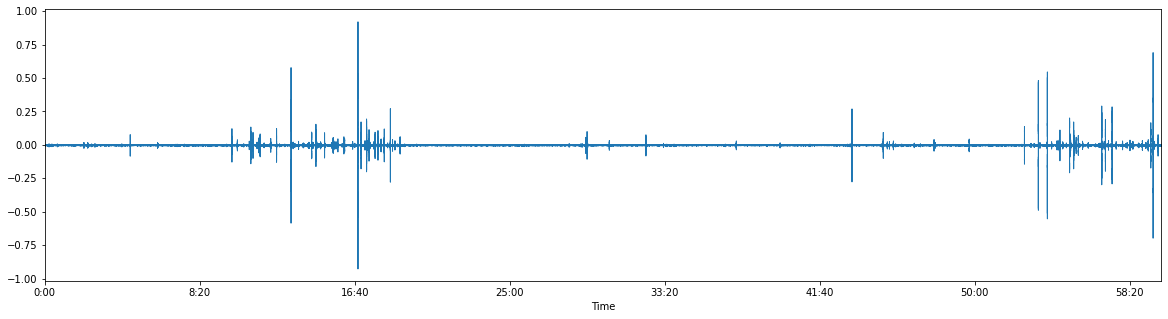

In [12]:
plt.figure(figsize=(20,5))
display.waveplot(samples,sr=sampling_rate)

In [13]:
sample_filt=filt(samples)

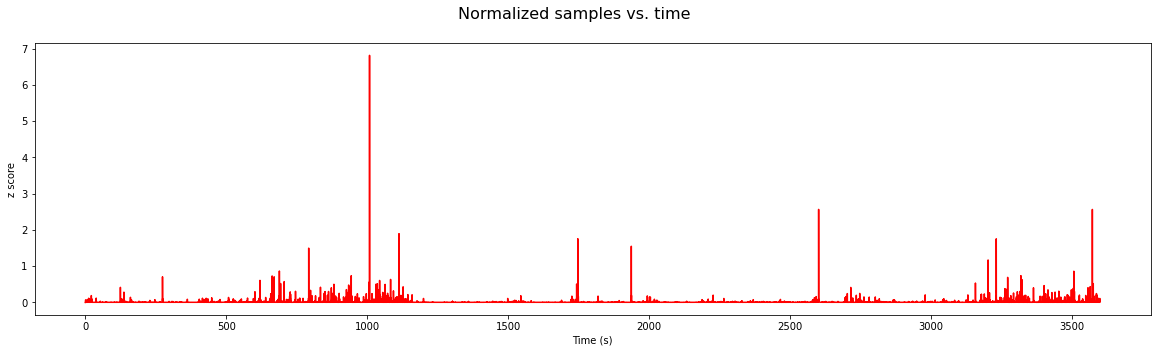

In [14]:
sm_env, z_env, times = norm_envelope(sample_filt, sampling_rate, win_length=1024*5, win_step=1024)
figure,ax1 = plt.subplots()
figure.set_size_inches(20,5)
#ax1.plot(times,sm_env[0],color='red')
ax1.plot(times,z_env[0],color='red')
#ax1.plot(x_time,samples,color='blue')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("z score")
figure.suptitle('Normalized samples vs. time', fontsize=16)
#ax1.set_xlim(120,150)
#ax1.set_ylim(0,1)
plt.show()

In [15]:
np.std(sm_env[0])

0.00029650287

In [16]:
probability_each_point = state_probability(z_env)

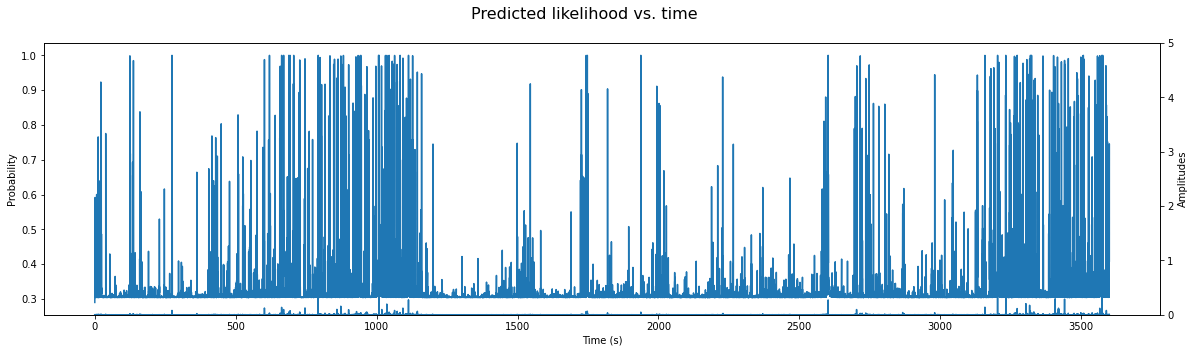

In [17]:
figure,ax1 = plt.subplots()
figure.suptitle('Predicted likelihood vs. time', fontsize=16)
figure.set_size_inches(20,5)
ax1.plot(times,probability_each_point[0])
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Probability")
#ax1.set_xlim(110,170)
ax2=ax1.twinx()
ax2.plot(x_time, samples)
ax2.set_ylabel("Amplitudes")
ax2.set_ylim(0,5)
plt.show()

In [19]:
prob = prob_generate(probability_each_point)
states = librosa.sequence.viterbi_discriminative(prob,transition_matrix, p_init=p_init)
states= 1-states

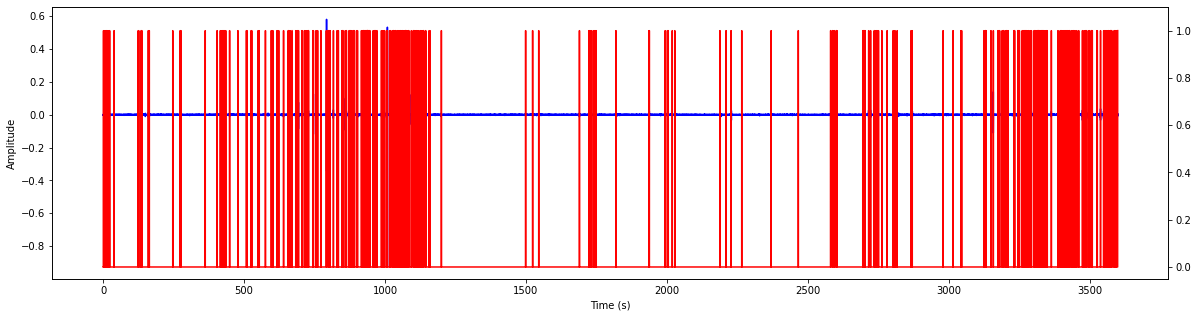

In [35]:
figure,ax1 = plt.subplots()
figure.set_size_inches(20,5)
ax1.plot(x_time,samples,color='blue')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")

ax2 = ax1.twinx()
ax2.plot(times,states,color='red')
ax2.set_ylim(-0.05,1.1)
#plt.xlim(400,498)
plt.show()

In [21]:
import pickle
pickle_out = open("state.pickle","wb")
pickle.dump(states,pickle_out)
pickle_out.close()

In [22]:
pickle_in = open("state.pickle","rb")
states = pickle.load(pickle_in)

In [23]:
start_call_index=[]
end_call_index=[]
for i in range(0,len(states)-1):
  if(i==0):
    if(states[i]==1):
      start_call_index.append(i)
  if((states[i]==0)and(states[i+1]==1)):
    start_call_index.append(i+1)
  elif((states[i]==1)and(states[i+1]==0)):
    end_call_index.append(i)
  i=i+1

if(states[len(states)-1]==1):
  end_call_index.append(len(states)-1)

if((len(start_call_index)==0)and(len(end_call_index)==0)and(states[0]==1)and(states[-1]==1)):
  start_call_index.append(0)
  end_call_index.append(len(states)-1)

In [24]:
#need the time conversion
start_samples_time = [(i*1024)/44100 for i in start_call_index]
end_samples_time = [(i*1024)/44100 for i in end_call_index]

In [25]:
df = pd.DataFrame({'start': start_samples_time, 'end': end_samples_time})

In [26]:
df.head(10)

,start,end
0,1.091338,1.184218
1,6.524807,6.617687
2,7.035646,7.128526
3,11.447438,11.540317
4,11.981497,12.074376
5,16.253968,16.346848
6,21.292698,21.408798
7,22.825215,22.918095
8,38.707664,38.800544
9,124.458957,124.621497


In [27]:
len(df)

382

In [29]:
df_new_processed = recursive_processing(df)

another round
another round
another round
another round
another round


In [30]:
'''
#remove segments with duration less than 5s
def get_longer_rows(df):
  processed_start_time=[]
  processed_end_time=[]
  for i in range(0,len(df)):
    if((df.iloc[i,1]-df.iloc[i,0])>5):
      processed_start_time.append(df.iloc[i,0])
      processed_end_time.append(df.iloc[i,1])
  df_processed = pd.DataFrame({'start': processed_start_time, 'end': processed_end_time})
  return df_processed
'''

In [31]:
def_shorter = df_new_processed
file_name = os.path.basename(file_path)
csv_name = file_name+'_timestamps.csv'
'''
def_shorter.to_csv(csv_name) #exporting timestampls to csv
df = pd.read_csv('/content/01-F818D-F8387-220616_0905_3_timestamps.csv',header='infer',index_col=0)
df.head()
'''

"\ndef_shorter.to_csv(csv_name) #exporting timestampls to csv\ndf = pd.read_csv('/content/01-F818D-F8387-220616_0905_3_timestamps.csv',header='infer',index_col=0)\ndf.head()\n"

In [32]:
rate, data = wavfile.read(file_path) 

In [33]:
#exporting the non-silent chunks
for i in range(0,len(def_shorter)-1):
  start_cut_time = def_shorter.iloc[i,0] - 2
  end_cut_time = def_shorter.iloc[i,1] + 2

  segment = data[int(start_cut_time*rate):int(end_cut_time*rate)]  # split

  output_name = file_name+'_'+str(i)+'_'+str(int(start_cut_time))+'_'+str(int(end_cut_time))+'.wav'
  print(output_name)
  wavfile.write(os.path.join('/content/drive/MyDrive/random test/wave_segments',output_name), rate, segment)

02-F832F-F837D-220615_1835_1_0_0_3.wav
02-F832F-F837D-220615_1835_1_1_4_24.wav
02-F832F-F837D-220615_1835_1_2_36_40.wav
02-F832F-F837D-220615_1835_1_3_122_127.wav
02-F832F-F837D-220615_1835_1_4_132_139.wav
02-F832F-F837D-220615_1835_1_5_158_165.wav
02-F832F-F837D-220615_1835_1_6_244_248.wav
02-F832F-F837D-220615_1835_1_7_271_276.wav
02-F832F-F837D-220615_1835_1_8_360_364.wav
02-F832F-F837D-220615_1835_1_9_402_406.wav
02-F832F-F837D-220615_1835_1_10_413_417.wav
02-F832F-F837D-220615_1835_1_11_419_431.wav
02-F832F-F837D-220615_1835_1_12_432_436.wav
02-F832F-F837D-220615_1835_1_13_446_450.wav
02-F832F-F837D-220615_1835_1_14_476_480.wav
02-F832F-F837D-220615_1835_1_15_506_511.wav
02-F832F-F837D-220615_1835_1_16_522_529.wav
02-F832F-F837D-220615_1835_1_17_547_555.wav
02-F832F-F837D-220615_1835_1_18_573_577.wav
02-F832F-F837D-220615_1835_1_19_594_598.wav
02-F832F-F837D-220615_1835_1_20_599_604.wav
02-F832F-F837D-220615_1835_1_21_614_624.wav
02-F832F-F837D-220615_1835_1_22_637_642.wav
02-F832

In [34]:
#exporting the silent chuncks just for checking
for i in range(0,len(def_shorter)-2):
  start_cut_time = def_shorter.iloc[i,1]
  end_cut_time = def_shorter.iloc[i+1,0]
  # get the frame to split at

  segment = data[int(start_cut_time*rate):int(end_cut_time*rate)]  # split

  output_name = file_name+'_silent_'+str(i)+'_'+str(int(start_cut_time))+'_'+str(int(end_cut_time))+'.wav'
  print(output_name)
  wavfile.write(os.path.join('/content/drive/MyDrive/random test/wave_segments',output_name), rate, segment)

02-F832F-F837D-220615_1835_1_silent_0_1_6.wav
02-F832F-F837D-220615_1835_1_silent_1_22_38.wav
02-F832F-F837D-220615_1835_1_silent_2_38_124.wav
02-F832F-F837D-220615_1835_1_silent_3_125_134.wav
02-F832F-F837D-220615_1835_1_silent_4_137_160.wav
02-F832F-F837D-220615_1835_1_silent_5_163_246.wav
02-F832F-F837D-220615_1835_1_silent_6_246_273.wav
02-F832F-F837D-220615_1835_1_silent_7_274_362.wav
02-F832F-F837D-220615_1835_1_silent_8_362_404.wav
02-F832F-F837D-220615_1835_1_silent_9_404_415.wav
02-F832F-F837D-220615_1835_1_silent_10_415_421.wav
02-F832F-F837D-220615_1835_1_silent_11_429_434.wav
02-F832F-F837D-220615_1835_1_silent_12_434_448.wav
02-F832F-F837D-220615_1835_1_silent_13_448_478.wav
02-F832F-F837D-220615_1835_1_silent_14_478_508.wav
02-F832F-F837D-220615_1835_1_silent_15_509_524.wav
02-F832F-F837D-220615_1835_1_silent_16_527_549.wav
02-F832F-F837D-220615_1835_1_silent_17_553_575.wav
02-F832F-F837D-220615_1835_1_silent_18_575_596.wav
02-F832F-F837D-220615_1835_1_silent_19_596_601.w

####Official Execution

In [11]:
def run_viterbi(file_path):
  samples, sampling_rate, duration = load_wav(file_path)
  x_time = np.arange(0,duration,1/sampling_rate)
  sample_filt=filt(samples)
  sm_env, z_env, times = norm_envelope(sample_filt, sampling_rate, win_length=1024*5, win_step=1024)
  '''
  figure,ax1 = plt.subplots()
  figure.set_size_inches(20,5)
  #ax1.plot(times,sm_env[0],color='red')
  ax1.plot(times,z_env[0],color='red')
  #ax1.plot(x_time,samples,color='blue')
  ax1.set_xlabel("Time (s)")
  ax1.set_ylabel("z score")
  figure.suptitle('Normalized samples vs. time', fontsize=16)
  #ax1.set_xlim(120,150)
  #ax1.set_ylim(0,1)
  plt.show()
  '''
  probability_each_point = state_probability(z_env)
  ''' 
  figure,ax1 = plt.subplots()
  figure.suptitle('Predicted likelihood vs. time', fontsize=16)
  figure.set_size_inches(20,5)
  ax1.plot(times,probability_each_point[0])
  ax1.set_xlabel("Time (s)")
  ax1.set_ylabel("Probability")
  #ax1.set_xlim(110,170)
  ax2=ax1.twinx()
  ax2.plot(x_time, samples)
  ax2.set_ylabel("Amplitudes")
  ax2.set_ylim(0,5)
  plt.show()
  '''
  prob = prob_generate(probability_each_point)
  states = librosa.sequence.viterbi_discriminative(prob,transition_matrix, p_init=p_init)
  states= 1-states
  '''
  figure,ax1 = plt.subplots()
  figure.set_size_inches(20,5)
  ax1.plot(x_time,samples,color='blue')
  ax1.set_xlabel("Time (s)")
  ax1.set_ylabel("Amplitude")

  ax2 = ax1.twinx()
  ax2.plot(times,states,color='red')
  ax2.set_ylim(-0.05,1.1)
  #plt.xlim(400,498)
  plt.show()
  '''
  return states

In [12]:
def second_step(states,file_path,output_path):
  start_call_index=[]
  end_call_index=[]
  for i in range(0,len(states)-1):
    if(i==0):
      if(states[i]==1):
        start_call_index.append(i)
    if((states[i]==0)and(states[i+1]==1)):
      start_call_index.append(i+1)
    elif((states[i]==1)and(states[i+1]==0)):
      end_call_index.append(i)
    i=i+1

  if(states[len(states)-1]==1):
    end_call_index.append(len(states)-1)

  if((len(start_call_index)==0)and(len(end_call_index)==0)and(states[0]==1)and(states[-1]==1)):
    start_call_index.append(0)
    end_call_index.append(len(states)-1)

  #need the time conversion
  start_samples_time = [(i*1024)/44100 for i in start_call_index]
  end_samples_time = [(i*1024)/44100 for i in end_call_index]

  df = pd.DataFrame({'start': start_samples_time, 'end': end_samples_time})
  df_new_processed = recursive_processing(df)

  def_shorter = df_new_processed
  file_name = os.path.basename(file_path)
  csv_name = file_name+'_timestamps.csv'
  rate, data = wavfile.read(file_path) 

  for i in range(0,len(def_shorter)-1):
    start_cut_time = def_shorter.iloc[i,0] - 2
    end_cut_time = def_shorter.iloc[i,1] + 2

    segment = data[int(start_cut_time*rate):int(end_cut_time*rate)]  # split

    output_name = file_name+'_'+str(i)+'_'+str(int(start_cut_time))+'_'+str(int(end_cut_time))+'.wav'
    print(output_name)
    wavfile.write(os.path.join(output_path,output_name), rate, segment)

In [13]:
def call_state_segmentation(file_path,output_path):
  states = run_viterbi(file_path)
  second_step(states,file_path,output_path)

In [14]:
#running on rapping samples in F818D-F8387
output_path = '/content/drive/MyDrive/Xenopus_male_female_data/overall_copy/laevis/F818D-F8387/duets/segmented/rapping'
rapping_dir = '/content/drive/MyDrive/Xenopus_male_female_data/overall_copy/laevis/F818D-F8387/duets/chunks/rapping'
for filename in os.listdir(rapping_dir):
  call_state_segmentation(os.path.join(rapping_dir,filename),output_path)
  print(os.path.join(rapping_dir),filename)

01-F818D-F8387-220615_1834_1_0_297_301.wav
01-F818D-F8387-220615_1834_1_1_417_421.wav
01-F818D-F8387-220615_1834_1_2_424_428.wav
01-F818D-F8387-220615_1834_1_3_432_442.wav
01-F818D-F8387-220615_1834_1_4_455_460.wav
01-F818D-F8387-220615_1834_1_5_461_465.wav
01-F818D-F8387-220615_1834_1_6_467_472.wav
01-F818D-F8387-220615_1834_1_7_476_481.wav
01-F818D-F8387-220615_1834_1_8_482_487.wav
01-F818D-F8387-220615_1834_1_9_489_494.wav
01-F818D-F8387-220615_1834_1_10_498_502.wav
01-F818D-F8387-220615_1834_1_11_508_513.wav
01-F818D-F8387-220615_1834_1_12_515_520.wav
01-F818D-F8387-220615_1834_1_13_522_526.wav
01-F818D-F8387-220615_1834_1_14_529_533.wav
01-F818D-F8387-220615_1834_1_15_535_539.wav
01-F818D-F8387-220615_1834_1_16_541_545.wav
01-F818D-F8387-220615_1834_1_17_552_557.wav
01-F818D-F8387-220615_1834_1_18_647_651.wav
01-F818D-F8387-220615_1834_1_19_660_664.wav
01-F818D-F8387-220615_1834_1_20_669_673.wav
01-F818D-F8387-220615_1834_1_21_954_958.wav
01-F818D-F8387-220615_1834_1_22_962_967.wa

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


IsADirectoryError: ignored